In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import *
from collections import Counter
import seaborn as sns
import pandas as pd
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
IMAGE_DIR = 'image_contest_level_2_validate'
CROP_DIR = 'crop_split2_test'

from multiprocessing import Pool, Lock, Manager

# 数据并行预处理

In [2]:
def f(index):
    img = cv2.imread('%s/%d.png'%(IMAGE_DIR, index))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    eq = cv2.equalizeHist(gray)
    b = cv2.medianBlur(eq, 9)
    
    m, n = img.shape[:2]
    b2 = cv2.resize(b, (n//4, m//4))

    m1 = cv2.morphologyEx(b2, cv2.MORPH_OPEN, np.ones((7, 40)))
    m2 = cv2.morphologyEx(m1, cv2.MORPH_CLOSE, np.ones((4, 4)))
    _, bw = cv2.threshold(m2, 127, 255, cv2.THRESH_BINARY_INV)
    
    bw = cv2.resize(bw, (n, m))

    img2, ctrs, hier = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(ctrs) > 3:
        print index
    
    # 微调三个公式
    d = 20
    d2 = 5
    imgs = []
    sizes = []
    for i, ctr in enumerate(ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        if w*h < 1000:
            continue
        roi = img[max(0, y-d):min(m, y+h+d),max(0, x-d):min(n, x+w+d)]
        p, q, _ = roi.shape
        
        x = b[max(0, y-d):min(m, y+h+d),max(0, x-d):min(n, x+w+d)]
        x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, np.ones((3, 3)))
        _, x = cv2.threshold(x, 127, 255, cv2.THRESH_BINARY_INV)
        _, x, _ = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(np.vstack(x))
        roi2 = roi[max(0, y-d2):min(p, y+h+d2),max(0, x-d2):min(q, x+w+d2)]
        imgs.append(roi2)
        sizes.append(roi2.shape)
        cv2.imwrite('%s/%d_%d.png'%(CROP_DIR, index, i), roi2)
    
    # 连接三个公式
    sizes = np.array(sizes)
    img = np.zeros((sizes[:,0].max(), sizes[:,1].sum()+(len(sizes)-1)*2, 3), dtype=np.uint8)
    x = 0
    for a in imgs[::-1]:
        iw = a.shape[1]
        img[:a.shape[0], x:x+iw] = a
        x += iw + 2
    
    cv2.imwrite('%s/%d.png'%(CROP_DIR, index), img)
    
    return [index, len(sizes)]

In [3]:
%%time

try:
    p
except:
    p = Pool(12)

n = 100000
if __name__ == '__main__':
    rs = []
    for r in tqdm(p.imap_unordered(f, range(n)), total=n):
        rs.append(r)

100%|██████████| 100000/100000 [24:26<00:00, 57.90it/s]

CPU times: user 20.6 s, sys: 3.27 s, total: 23.8 s
Wall time: 24min 26s


In [4]:
import struct
import imghdr

def get_image_size(fname):
    '''Determine the image type of fhandle and return its size.
    from draco'''
    with open(fname, 'rb') as fhandle:
        head = fhandle.read(24)
        if len(head) != 24:
            return
        if imghdr.what(fname) == 'png':
            check = struct.unpack('>i', head[4:8])[0]
            if check != 0x0d0a1a0a:
                return
            width, height = struct.unpack('>ii', head[16:24])
        elif imghdr.what(fname) == 'gif':
            width, height = struct.unpack('<HH', head[6:10])
        elif imghdr.what(fname) == 'jpeg':
            try:
                fhandle.seek(0) # Read 0xff next
                size = 2
                ftype = 0
                while not 0xc0 <= ftype <= 0xcf:
                    fhandle.seek(size, 1)
                    byte = fhandle.read(1)
                    while ord(byte) == 0xff:
                        byte = fhandle.read(1)
                    ftype = ord(byte)
                    size = struct.unpack('>H', fhandle.read(2))[0] - 2
                # We are at a SOFn block
                fhandle.seek(1, 1)  # Skip `precision' byte.
                height, width = struct.unpack('>HH', fhandle.read(4))
            except Exception: #IGNORE:W0703
                return
        else:
            return
        return width, height

In [8]:
sizes = []
for i in tqdm(range(100000)):
    fname = '%s/%d.png'%(CROP_DIR, i)
    size = get_image_size(fname)
    sizes.append(size)

100%|██████████| 100000/100000 [00:01<00:00, 68454.66it/s]


In [9]:
s = np.array(sizes)
print 'wmin wmax hmin hmax'
print s[:,0].min(), s[:,0].max(), s[:,1].min(), s[:,1].max()

wmin wmax hmin hmax
525 899 51 80


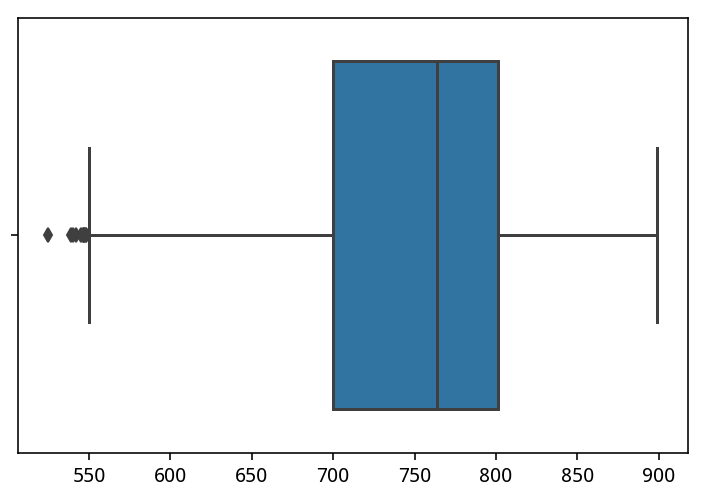

In [10]:
sns.boxplot(s[:,0])

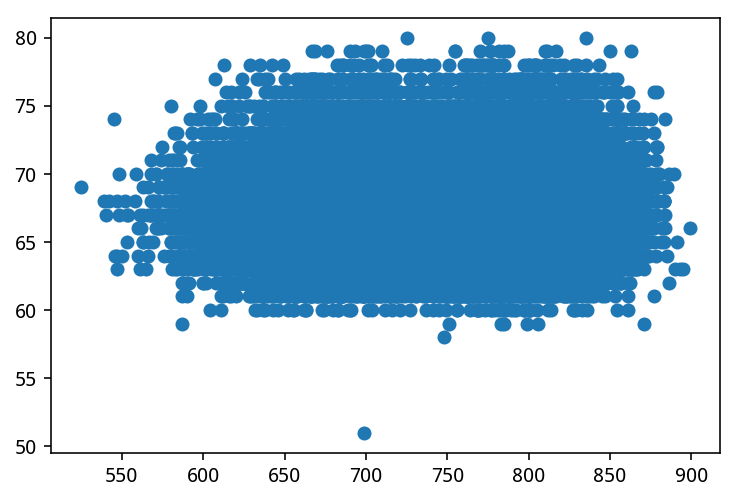

In [11]:
plt.scatter(s[:,0], s[:,1])

In [15]:
s[:,1].argmin()

95170

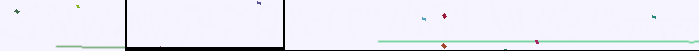

In [16]:
Image('%s/%d.png'%(CROP_DIR, 95170))

# 结果可视化

In [17]:
def disp2(img):
    cv2.imwrite('a.png', img)
    return display(Image('a.png'))


def disp(img, txt=None, first=False):
    global index
    if first:
        index = 1
        plt.figure(figsize=(16, 9))
    else:
        index += 1
    plt.subplot(4, 3, index)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    if txt:
        plt.title(txt)

# 技术原理

* [转灰度图](http://docs.opencv.org/master/df/d9d/tutorial_py_colorspaces.html)
* [二值化](http://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html)
* [直方图均衡](http://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html)
* [中值滤波](http://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html)
* [开运算](http://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html)
* [轮廓查找](http://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html)
* [边界矩形](http://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html)

参考链接：

* http://docs.opencv.org/master/df/d9d/tutorial_py_colorspaces.html
* http://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
* http://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html
* http://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
* http://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html
* http://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html
* http://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html

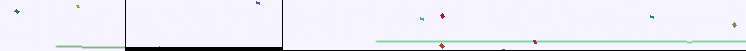

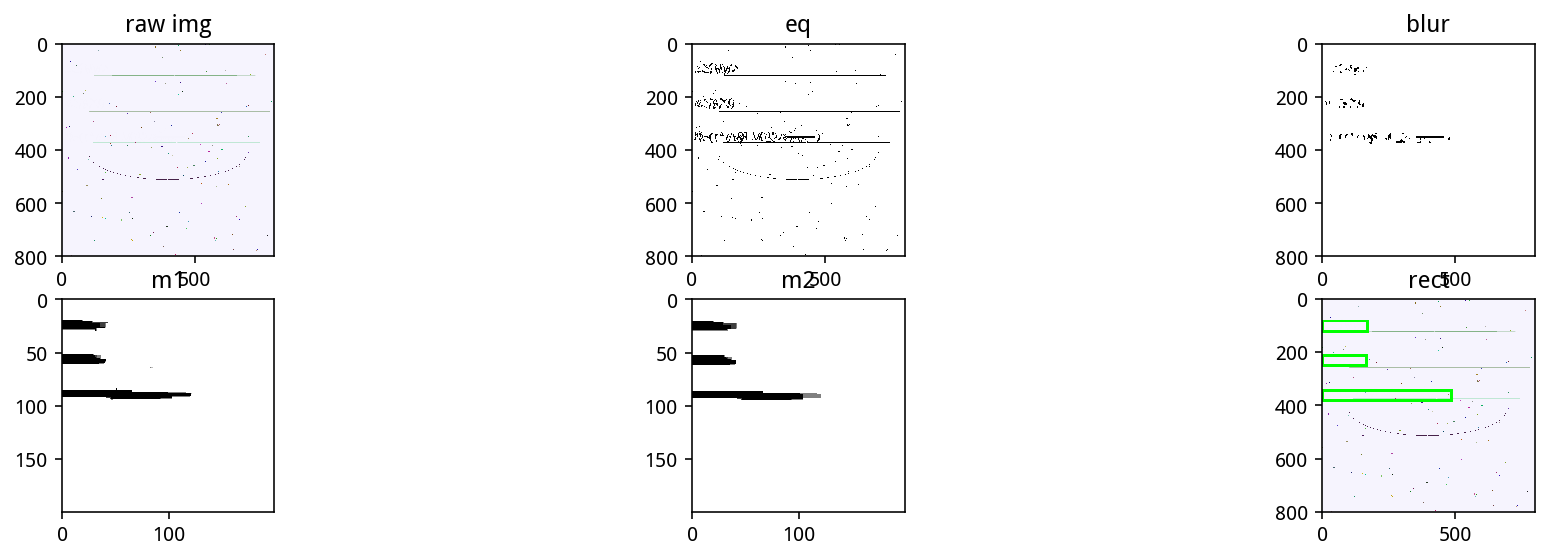

In [40]:
def plot(index):
    global img, gray, b, eq, bw, m, n, m1, m2, r, roi, ctrs, d, d2
    img = cv2.imread('%s/%d.png'%(IMAGE_DIR, index))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    eq = cv2.equalizeHist(gray)
    b = cv2.medianBlur(eq, 9)
    
    m, n = img.shape[:2]
    b2 = cv2.resize(b, (n//4, m//4))

    m1 = cv2.morphologyEx(b2, cv2.MORPH_OPEN, np.ones((7, 40)))
    m2 = cv2.morphologyEx(m1, cv2.MORPH_CLOSE, np.ones((4, 4)))
    _, bw = cv2.threshold(m2, 192, 255, cv2.THRESH_BINARY_INV)
    
    bw = cv2.resize(bw, (n, m))

    r = img.copy()
    img2, ctrs, hier = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for ctr in ctrs:
        x, y, w, h = cv2.boundingRect(ctr)
        cv2.rectangle(r, (x, y), (x+w, y+h), (0, 255, 0), 10)
    x, y, w, h = cv2.boundingRect(np.vstack(ctrs))
    
    disp(img, 'raw img', 1)
    disp(eq, 'eq')
    disp(b, 'blur')
    disp(m1, 'm1')
    disp(m2, 'm2')
    disp(r, 'rect')
    
    # 微调三个公式
    d = 20
    d2 = 5
    imgs = []
    sizes = []
    for i, ctr in enumerate(ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        roi = img[max(0, y-d):min(m, y+h+d),max(0, x-d):min(n, x+w+d)]
        p, q, _ = roi.shape
        
        x = b[max(0, y-d):min(m, y+h+d),max(0, x-d):min(n, x+w+d)]
        x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, np.ones((3, 3)))
        _, x = cv2.threshold(x, 127, 255, cv2.THRESH_BINARY_INV)
        _, x, _ = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(np.vstack(x))
        roi2 = roi[max(0, y-d2):min(p, y+h+d2),max(0, x-d2):min(q, x+w+d2)]
        imgs.append(roi2)
        sizes.append(roi2.shape)
    
    # 连接三个公式
    sizes = np.array(sizes)
    img2 = np.zeros((sizes[:,0].max(), sizes[:,1].sum()+len(sizes)-1, 3), dtype=np.uint8)
    x = 0
    for a in imgs[::-1]:
        w = a.shape[1]
        img2[:a.shape[0], x:x+w] = a
        x += w + 1
    
    return disp2(img2)
    

plot(95170)

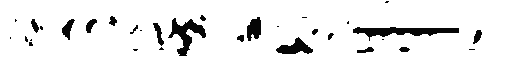

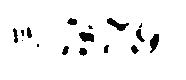

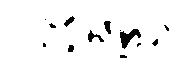

In [52]:
for i, ctr in enumerate(ctrs):
    x, y, w, h = cv2.boundingRect(ctr)
    roi = img[max(0, y-d):min(m, y+h+d),max(0, x-d):min(n, x+w+d)]
    roi3 = eq[max(0, y-d):min(m, y+h+d),max(0, x-d):min(n, x+w+d)]
    
    p, q, _ = roi.shape

    x = b[max(0, y-d):min(m, y+h+d),max(0, x-d):min(n, x+w+d)]
#     x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, np.ones((3, 3)))
#     _, x = cv2.threshold(x, 127, 255, cv2.THRESH_BINARY_INV)
#     _, x, _ = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     x, y, w, h = cv2.boundingRect(np.vstack(x))
#     roi2 = roi3[max(0, y-d2):min(p, y+h+d2),max(0, x-d2):min(q, x+w+d2)]
    disp2(x)
#     disp2(roi2)